## init

[Логистическая функция ошибки, Дьяконов](https://dyakonov.org/2018/03/12/%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F-%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8/)

* $L_1$-регуляризация - **Ridge**;   
* $L_2$-регуляризация - **Lasso**;   
* обе две - **ElasticNet**.   

In [16]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
# украшаем графики
plt.rcParams["figure.figsize"] = (17,8)
plt.style.use('ggplot')

In [19]:
from src import utils

## data

In [20]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_classes=2)

In [21]:
X[:5]

array([[-1.13793624, -1.26910825],
       [ 0.90927234,  1.65836079],
       [ 1.22309295,  1.77986155],
       [ 1.16381691, -1.71638139],
       [ 0.98998619,  1.55877872]])

In [22]:
y[:5]

array([0, 1, 1, 0, 1])

## baseline

In [24]:
slr = SklearnLogisticRegression(fit_intercept=True)
slr = slr.fit(X, y)

y_pred = slr.predict_proba(X)[:, 1]

roc_auc_score(y, y_pred)

0.9707883153261304

In [29]:
baseline_coefs = [slr.intercept_[0]] + list(slr.coef_[0])

baseline_coefs

[0.2755436708034343, 0.0004099851535844097, 2.4531032869880334]

## LogisticRegression

Итак, у нас n фичей и m объектов (векторов $ x^{(i)} $ длины n) - матрица X. Есть вектор y длины m с целевой - по одному значению на объект $ x^{(i)} $. Функция для приближения - линейная:    
$$ z = h_\theta(x) :=\sum\limits_{j=0}^n \theta_j x_j $$  

На выходе (z) мы получаем некоторое значение, которое зачастую называт "логит". Почему? А есть такая функция, логит-функция:  
$$logit(p) = \log{\frac{p}{1-p}} = \log{p} - \log{(1-p)}$$  

Т.е. это функция от вероятности ($p$), которая переводит вероятность (значения от 0 до 1) в значения из $(-\inf, +\inf)$. И существует обратная ей функция, сигмоида:  
$$ p = \frac{1}{1 + e^{-x}} = \frac{1}{1 + exp(-x)} $$  

Она наоборот, переводит значение из $(-\inf, +\inf)$ в вероятность - значения от 0 до 1 (я тут специально выделяю $exp()$ как функцию, обратную $\log{p}$, если рассматривать натуральный логарифм, конечно). И вот она-то нам и понадобится.

Ещё заметим, что логит-функцию называют _логарифмом шансов_. Ибо выражение ${\frac{p}{1-p}}$, по сути - это другое представление вероятности, в виде шансов: сказать, что шансы победить 3 к 1 - это то же самое, что сказать, что вероятность победить равна 0.75:  
$$\frac{p}{1-p} = \frac{3}{1} \implies \frac{p}{1-p} = 3 \implies p = 3(1-p) \implies p = 3 - 3p \implies p+3p = 3 \implies 4p = 3 \implies p = \frac{3}{4} = 0.75 $$  

На английском запись вероятности в виде шансов зовётся _odds_. Шансы принимают значения из $(0, +\inf)$. Тоже хорошо, но не достаточно симметрично. Вероятности от 0 до 0.5 в виде шансов принимают значения от 0 до 1. А вероятности от 0.5 до 1 - от 1 до $+\inf$. Вероятность же 0.5 - это один к одному, $\frac{1}{1} = 1$.  

А вот когда мы берем от этого логарифм, логит, получается красиво: вероятность 0.5 - в нуле, вероятности менее 0.5 - отрицательные, более 0.5 - положительные. Причем логиты от вероятностей 0.25 и 0.75, например, равноудалены от нуля (как сами вероятности равноудалены от 0.5).  

Итак, чтобы получить из логита, нашего значения z, вероятность, применяем функцию-сигмоид:  
$$ P(y=1) = \frac{1}{1 + e^{-z}} $$  

Получили вероятность того, что наше истинное значение y равно единице. Теперь надо сформулировать лосс, как будем считать ошибку?  

А вот так:  
$$
\begin{equation}
  -\begin{cases}
    \log(p), & если \: y = 1 \\
    \log(1-p), & если \: y = 0
  \end{cases}
\end{equation}
$$

Это, по сути, и есть _logloss_, логистическая функция ошибки. Здесь $p$ - вероятность $P(y=1)$, т.е. $(1-p)$ - это вероятность $P(y=0)$. Т.е. мы берем минус логарифм вероятности того $y$, который на самом деле есть.  

Можно сказать так: назовём $P(y=0)$ буквой $q$. Тогда $ p = \frac{1}{1 + e^{-z}}$, $ q = 1 - p $, и  
$$
\begin{equation}
  logloss = -\begin{cases}
    \log(p), & если \: y = 1 \\
    \log(q), & если \: y = 0
  \end{cases}
\end{equation}
$$  

В одно выражение это можно собрать так:  
$$ logloss(p, y) = -y \cdot \log(p) - (1-y) \cdot \log(1 - p) $$  

Идея в том, что если $y=1$, то мы идём по первому слагаемому, а второе обращается в 0 (т.к. множитель $(1-y)$ обращается в ноль при $y=1$); если же $y=0$, то наоборот: первое слагаемое обращается в 0, и мы получаем только второе.  

В общем, главный прикол вот в чем (пока на одном объекте):  
$$  
L(p, y) = -y \cdot \log(p) - (1-y) \cdot \log(1 - p) \\
p = sigmoid(\theta \cdot x) = \frac{1}{1+e^{\theta \cdot x}} \\
\frac {\partial L}{\partial \theta} = (p-y)x
$$  

> надо бы это вывести

****

Наша задача - найти оптимальные коэффициенты (вектор $ \theta $), которые минимизируют логистическую функцию потерь (на данном датасете X):  
$$ L(\theta, X, y) = \sum\limits_{i=1}^m \ln(1 + e^{-y^{(i)} h_\theta(x^{(i)})}) $$   

Частная производная по i-той координате вектора $ \theta $ на нескольких объектах (батче длины m) будет такой:  
$$ \frac {\partial }{\partial \theta_j} \sum\limits_{i=1}^m \ln(1 + e^{-y^{(i)} h_\theta(x^{(i)})}) = \sum\limits_{i=1}^m \frac {-y^{(i)} e^{-y^{(i)} h_\theta(x^{(i)})} }{1 + e^{-y^{(i)} h_\theta(x^{(i)})} } * x_j^{(i)} $$  

> **здесь мы берем значения _y_ из {1, -1}, а не {1, 0}**

****

In [65]:
class LogisticRegression(utils.LinearRegression): 
    def one_object_sigmoid(self, z: float) -> float:
        # переводим логарифм шансов в вероятность
        return 1 / (1 + np.e**(-z))
    
    def target_change(self, y: float) -> float:
        # [1, 0] -> [1, -1]
        if y == 0:
            return -1
        else:
            return y
    
    def batch_target_change(self, y: np.array) -> np.array:
        # [1, 0] -> [1, -1]
        y_copy = y.copy()
        y_copy[y_copy == 0] = -1
        return y_copy
    
    def one_object_predict_proba(self, x: np.array, theta: np.array) -> float:
        z = self.one_object_predict(x, theta)
        return self.one_object_sigmoid(z)
    
    def batch_predict_proba(self, X: np.array, theta: np.array) -> np.array:
        # предсказание для батча
        # X - уже матрица, а не вектор; на выходе - вектор, а не скаляр
        if self.fit_intercept and (len(X[0]) < len(theta)):
            X = np.insert(X, 0, 1, axis=1) # добавляем фиктивный признак
        y_pred = []
        for x_i in X:
            y_pred.append(self.one_object_predict_proba(x_i, theta))
        return np.array(y_pred)
    
    def one_object_loss(self, x: np.array, theta: np.array, y: float) -> float:
        # значение функции потерь для одного объекта
        y_changed = self.target_change(y)
        if self.fit_intercept and (len(x) < len(theta)):
            x = np.insert(x, 0, 1) # добавляем фиктивный признак
        predict = self.one_object_predict(x, theta)
        margin = y_changed * predict
        return np.log(1 + np.e**(-margin))
    
    def one_object_gradient(self, x: np.array, theta: np.array, y: float) -> np.array:
        # считаем градиент на одном объекте (там же сумма, можно для батча просуммировать)
        y_changed = self.target_change(y)
        if self.fit_intercept and (len(x) < len(theta)):
            x = np.insert(x, 0, 1) # добавляем фиктивный признак
        predict = self.one_object_predict(x, theta) # float
        margin = y_changed * predict
        powered_e = np.e**(-margin)
        
        const = -y_changed * powered_e / (1 + powered_e) 
        
        return x * const # array (new theta)

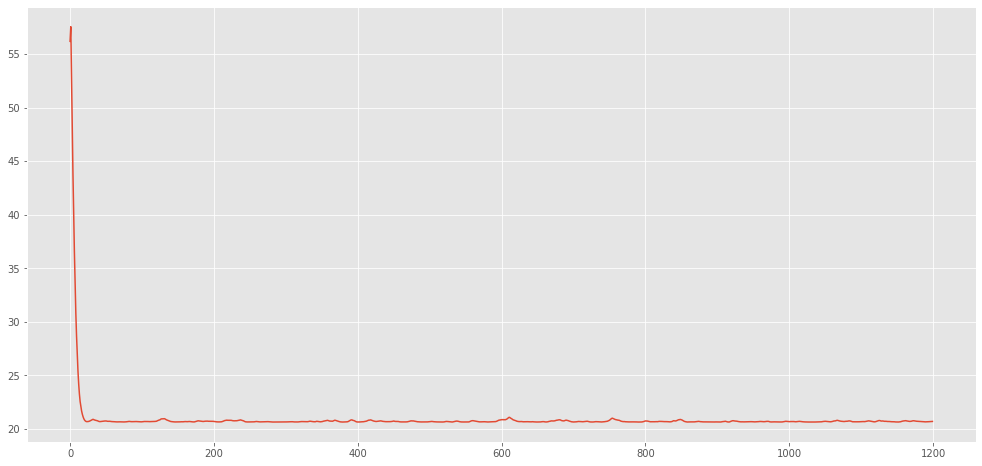

0.9715886354541816

In [83]:
lr = LogisticRegression()
sgd = utils.ADAM(learning_rate=0.1, round_ndigits=5, max_epoch_count=100, mini_batch_size=8, random_seed=0)

coefs = sgd.fit(lr, X, y)

y_pred = lr.batch_predict_proba(X, coefs)

roc_auc_score(y, y_pred)

In [79]:
coefs

array([0.42633561, 0.07078903, 3.15659487])

In [80]:
baseline_coefs

[0.2755436708034343, 0.0004099851535844097, 2.4531032869880334]

 Надо добавлять регуляризацию, похоже. И менять условие для выхода. А то не сходится нифига.